In [2]:
## loading package 
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 
from matplotlib import pylab
import seaborn as sns 
from sklearn.metrics.pairwise import cosine_similarity
from statannot import add_stat_annotation
import matplotlib as mpl
from scipy import stats, cluster
import glob
import re
from sklearn.metrics import mean_squared_error, r2_score
from statsmodels.stats import multitest
from matplotlib.gridspec import GridSpec

from matplotlib_venn import venn2, venn3
from matplotlib import pyplot as plt

import time
from scipy.stats.mstats import winsorize

import warnings 
warnings.simplefilter('ignore')

## load_large_dataFrame
def load_large_dataFrame(input_file, sep=",", header=0, index_col=0, chunksize=100000, compressed=False):
    if compressed:
        TextFileReader = pd.read_csv(input_file, chunksize=chunksize, sep=sep, header=header,index_col=index_col, compression='gzip')
    else:
        TextFileReader = pd.read_csv(input_file, chunksize=chunksize, sep=sep, header=header,index_col=index_col)
    dfList=[]
    for df in TextFileReader:
        dfList.append(df)
    final_df = pd.concat(dfList,sort=False)
    return final_df

# Heterogeneity of RNA Structures

## 1. Gene Heterogeneity by Cosine Distance

In [2]:
crude_reac = load_large_dataFrame("../Current_Data/04.Wide_Reac_Matrix_1nt/neural_differentiate.stages.transcripts.crude_reac.csv",
                                      header=[0,1,2,3], index_col=[0,1])
gnorm_reac = load_large_dataFrame("../Current_Data/04.Wide_Reac_Matrix_1nt/neural_differentiate.stages.transcripts.gnorm_reac.csv",
                                      header=[0,1,2,3], index_col=[0,1])


KeyboardInterrupt



### 1.1 Functions for cosine distance

In [5]:
from sklearn.metrics.pairwise import cosine_similarity, cosine_distances

def calculate_pairwise_cosine_distance(gene_reac_df, gene):
    ## pseudobulk of the stage
    concat_list = []
    detected_len_concat_list = []
    pseudobulk_reac = gene_reac_df.mean(axis=1).to_frame('pseudobulk')
    ## comparing each cell to the pseudobulk
    for col_idx, col in gene_reac_df.items():
        cell_reac = col.to_frame()
        cell_reac = cell_reac.dropna()
        local_pseudobulk = pseudobulk_reac.loc[cell_reac.index]
        if local_pseudobulk.index.size >= 100:
            cell2pseudo_reac_cosine_distance = cosine_distances(cell_reac.T, local_pseudobulk.T)[0,0]
            #cell2pseudo_reac_cosine_distance = cosine_similarity(cell_reac.T, local_pseudobulk.T)[0,0]
        else:
            cell2pseudo_reac_cosine_distance = np.nan
        detect_gene_len = cell_reac.index.size
        cell2pseudo_reac_cosine_distance = pd.DataFrame([[cell2pseudo_reac_cosine_distance]], columns=cell_reac.columns, index=[gene])
        detect_gene_len = pd.DataFrame([[detect_gene_len]], columns=cell_reac.columns, index=[gene])
        concat_list.append(cell2pseudo_reac_cosine_distance)
        detected_len_concat_list.append(detect_gene_len)
    cell2pseudo_reac_cosine_distance_matrix = pd.concat(concat_list, axis=1)
    detect_gene_len_matrix = pd.concat(detected_len_concat_list, axis=1)
    return cell2pseudo_reac_cosine_distance_matrix, detect_gene_len_matrix

def make_cosinde_distance_matrix_from_reac_matrix(crude_reac_matrix):
    concat_genes = []
    concat_gene_lens = []
    for (batch, stage), stage_reac in crude_reac_matrix.groupby(level=["batch","stage"], axis=1):
        local_concat_genes = []
        local_concat_gene_lens = []
        for gene, gene_reac in stage_reac.groupby(level="gene"):
            cell2pseudo_cosine_distance_matrix, detect_gene_len_matrix = calculate_pairwise_cosine_distance(gene_reac, gene)
            local_concat_genes.append(cell2pseudo_cosine_distance_matrix)
            local_concat_gene_lens.append(detect_gene_len_matrix)
        stage_cosine_distance_matrix = pd.concat(local_concat_genes)
        stage_gene_lens_matrix = pd.concat(local_concat_gene_lens)
        ## add columns to stage_cosine_distance_matrix
        # col_df = stage_cosine_distance_matrix.columns.to_frame()
        # col_df['stage'] = stage
        # stage_cosine_distance_matrix.columns = pd.MultiIndex.from_frame(col_df)
        ## add columns to stage_gene_lens_matrix
        # col_df = stage_gene_lens_matrix.columns.to_frame()
        # col_df['stage'] = stage
        # stage_gene_lens_matrix.columns = pd.MultiIndex.from_frame(col_df)
        concat_genes.append(stage_cosine_distance_matrix)
        concat_gene_lens.append(stage_gene_lens_matrix)    
    cosine_distance_matrix = pd.concat(concat_genes, axis=1)
    gene_lens_matrix = pd.concat(concat_gene_lens, axis=1)
    cosine_distance_matrix.columns.names = ['id','batch','stage','lib_type']
    return cosine_distance_matrix

### 1.2 Pairwise cosine distances matrix

In [6]:
cosinde_distance_matrix_from_crude_reac = make_cosinde_distance_matrix_from_reac_matrix(crude_reac)


KeyboardInterrupt



In [ ]:
#cosinde_distance_matrix_from_crude_reac.to_csv("../Current_Data/04.Gene_Heterogeneity/neural_differentiate.stages.transcripts.crude_reac.cosine_distance_matrix.csv")
cosinde_distance_matrix_from_crude_reac = load_large_dataFrame("../Current_Data/04.Gene_Heterogeneity/neural_differentiate.stages.transcripts.crude_reac.cosine_distance_matrix.csv", header=[0,1,2,3])

In [7]:
cosinde_distance_matrix_from_gnorm_reac = make_cosinde_distance_matrix_from_reac_matrix(gnorm_reac)
#cosinde_distance_matrix_from_gnorm_reac.to_csv("../Current_Data/04.Gene_Heterogeneity/neural_differentiate.stages.transcripts.gnorm_reac.cosine_distance_matrix.csv")

<AxesSubplot:xlabel='id-batch-stage-lib_type'>

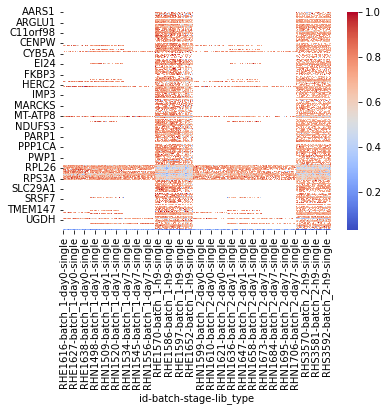

In [10]:
sns.heatmap(cosinde_distance_matrix_from_gnorm_reac, cmap="coolwarm", vmax=1)

In [32]:
scaled_reac = load_large_dataFrame("../Current_Data/03.Wide_Reac_Matrix_1nt/neural_differentiate.stages.transcripts.scaled_reac.csv", header=[0,1,2,3], index_col=[0,1])
cosinde_distance_matrix_from_scaled_reac = make_cosinde_distance_matrix_from_reac_matrix(scaled_reac)
cosinde_distance_matrix_from_scaled_reac.to_csv("../Current_Data/05.Gene_Heterogeneity/neural_differentiate.stages.transcripts.scaled_reac.cosine_distance_matrix.csv")

### 1.3 gene heterogeneity

In [3]:
cosinde_distance_matrix_from_crude_reac = load_large_dataFrame("../Current_Data/05.Gene_Heterogeneity/neural_differentiate.stages.transcripts.crude_reac.cosine_distance_matrix.csv", header=[0,1,2,3])
cosinde_distance_matrix_from_crude_reac

cosinde_distance_matrix_from_scaled_reac = load_large_dataFrame("../Current_Data/05.Gene_Heterogeneity/neural_differentiate.stages.transcripts.scaled_reac.cosine_distance_matrix.csv", header=[0,1,2,3])
cosinde_distance_matrix_from_scaled_reac

cosinde_distance_matrix_from_gnorm_reac = load_large_dataFrame("../Current_Data/05.Gene_Heterogeneity/neural_differentiate.stages.transcripts.gnorm_reac.cosine_distance_matrix.csv", header=[0,1,2,3])
cosinde_distance_matrix_from_gnorm_reac

id,RHE1616,RHE1617,RHE1618,RHE1619,RHE1620,RHE1621,RHE1622,RHE1623,RHE1624,RHE1625,...,RHS3587,RHS3588,RHS3589,RHS3590,RHS3591,RHS3592,RHS3593,RHS3594,RHS3595,RHS3596
batch,batch_1,batch_1,batch_1,batch_1,batch_1,batch_1,batch_1,batch_1,batch_1,batch_1,...,batch_2,batch_2,batch_2,batch_2,batch_2,batch_2,batch_2,batch_2,batch_2,batch_2
stage,day0,day0,day0,day0,day0,day0,day0,day0,day0,day0,...,h9,h9,h9,h9,h9,h9,h9,h9,h9,h9
lib_type,single,single,single,single,single,single,single,single,single,single,...,single,single,single,single,single,single,single,single,single,single
AARS1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.663704,NaN,NaN,0.716860,0.747379,NaN,NaN,0.725874,0.757770,0.598742
AC005329.1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.591384,0.725664,0.748357,0.710820,0.656970,0.572516,0.691128,0.743787,0.758632,NaN
AC009107.2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,0.591417,0.772902,NaN,NaN,NaN,0.808072,0.932049,0.634238,0.742718
AC009446.1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
AC010624.5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.706097,0.862357,NaN,0.431254,0.380816,0.706126,0.933139,NaN,0.271185,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ZNRD2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.618142,NaN,NaN,0.711588,0.771315,NaN,NaN,0.569690,0.655364,0.753318


In [4]:
def deviation_of_cosine_distance(cosine_dist_df):
    deviation_concat_list = []
    for gene, row in cosine_dist_df.iterrows():
        row = 1-(1 - row)
        deviation = np.sqrt((row.dropna().pow(2).sum()/row.dropna().size))
        deviation_df = pd.DataFrame([deviation], index=[gene], columns=['deviation'])
        deviation_concat_list.append(deviation_df)
    deviation_df = pd.concat(deviation_concat_list)
    return deviation_df
def calculate_heterogeneity_from_pairwise_cosine_distance_matrix(cosine_distance_matrix):
    concat_list = []
    for (batch,stage), subset_cosdist in cosine_distance_matrix.groupby(level=['batch','stage'], axis=1):

        deviation_df = deviation_of_cosine_distance(subset_cosdist)
        deviation_df.columns = pd.MultiIndex.from_tuples([(batch, stage)], names=['batch','stage'])
        concat_list.append(deviation_df)

        """detect_cell_matrix = subset_cosdist.notna().sum(axis=1).to_numpy()
        #print (detect_cell_matrix.shape)
        mean_cosdist = subset_cosdist.mean(axis=1, numeric_only=True)
        diff_cosdist = subset_cosdist.to_numpy() - mean_cosdist.to_frame().to_numpy()
        sqdiff_cosdist = np.nansum(np.square(diff_cosdist), axis=1)
        #print (np.sum(np.isnan(sqdiff_cosdist)))

        avgsqdiff_cosdist = np.nansum(np.square(diff_cosdist), axis=1)/detect_cell_matrix
        sqrtavgsqdiff_cosdist = np.sqrt(avgsqdiff_cosdist)
        out = pd.DataFrame(sqrtavgsqdiff_cosdist, index=subset_cosdist.index, columns=[stage])
        concat_list.append(out)"""

    gene_htg = pd.concat(concat_list, axis=1)
    gene_htg.index.name = "gene"
    return gene_htg


In [5]:
gene_htg_by_crude_reac = calculate_heterogeneity_from_pairwise_cosine_distance_matrix(cosinde_distance_matrix_from_crude_reac)
gene_htg_by_crude_reac

gene_htg_by_scaled_reac = calculate_heterogeneity_from_pairwise_cosine_distance_matrix(cosinde_distance_matrix_from_scaled_reac)
gene_htg_by_scaled_reac

gene_htg_by_gnorm_reac = calculate_heterogeneity_from_pairwise_cosine_distance_matrix(cosinde_distance_matrix_from_gnorm_reac)
gene_htg_by_gnorm_reac

batch         batch_1                                 batch_2            \
stage            day0      day1      day7        h9      day0      day1   
gene                                                                      
AARS1             NaN       NaN       NaN  0.761867       NaN       NaN   
AC005329.1        NaN       NaN       NaN  0.712555       NaN       NaN   
AC009107.2        NaN       NaN       NaN  0.749618       NaN       NaN   
AC009446.1        NaN       NaN       NaN       NaN       NaN       NaN   
AC010624.5        NaN       NaN       NaN  0.714568       NaN       NaN   
...               ...       ...       ...       ...       ...       ...   
ZNRD2             NaN       NaN       NaN  0.670788       NaN       NaN   
ZRANB2            NaN       NaN       NaN       NaN       NaN       NaN   
ZSCAN10           NaN       NaN       NaN  0.729161       NaN       NaN   
ZYX               NaN       NaN       NaN  0.712409       NaN       NaN   
human_small  0.269795  0.245702  0.284558  0.197137  0.288374  0.342664   

batch                           
stage           day7        h9  
gene                            
AARS1            NaN  0.708006  
AC005329.1       NaN  0.670586  
AC009107.2       NaN  0.681716  
AC009446.1       NaN       NaN  
AC010624.5       NaN  0.596731  
...              ...       ...  
ZNRD2            NaN  0.713621  
ZRANB2           NaN       NaN  
ZSCAN10          NaN  0.716663  
ZYX              NaN  0.688374  
human_small  0.32339  0.137819  

[1192 rows x 8 columns]

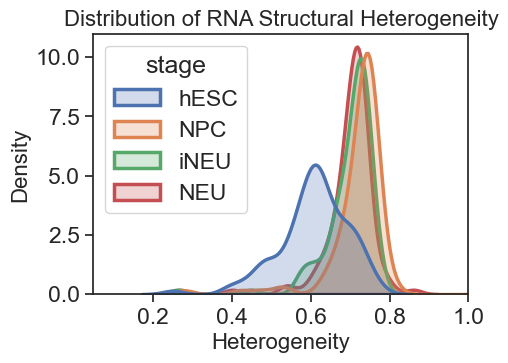

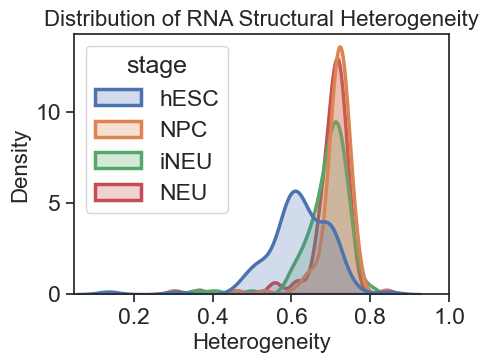

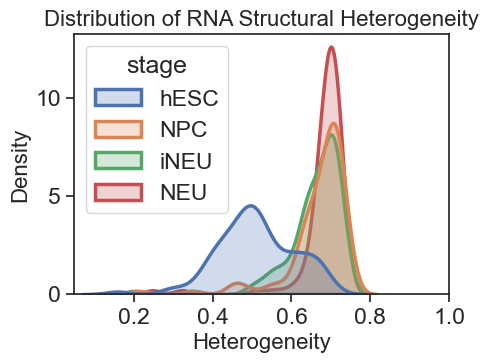

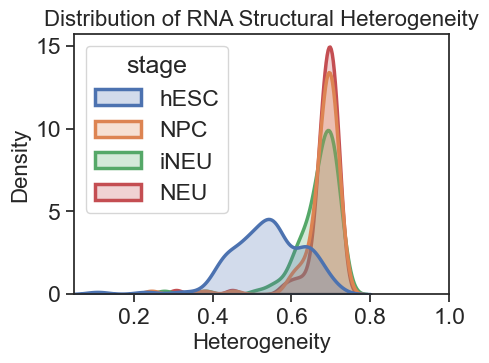

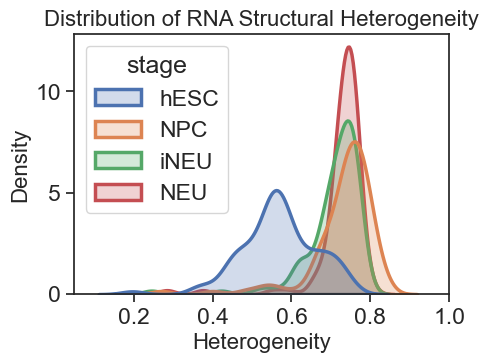

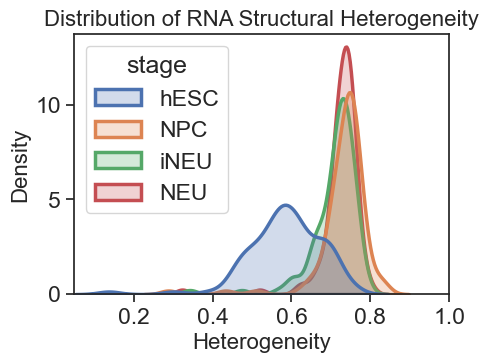

In [108]:
sns.reset_defaults()
gene_htg = gene_htg_by_crude_reac

def plot_distribution_of_gene_htg(gene_htg):
    stacked_gene_htg = gene_htg.dropna().stack([0,1]).to_frame('Heterogeneity').reset_index()
    stacked_gene_htg['stage'] = stacked_gene_htg['stage'].map({'h9':'hESC','day0':'NPC','day1':'iNEU','day7':'NEU'})
    t = pd.CategoricalDtype(categories=['hESC','NPC','iNEU','NEU'], ordered=True)
    stacked_gene_htg['stage'] = stacked_gene_htg['stage'].astype(t)
    for batch, subset in stacked_gene_htg.groupby('batch'):
        #if batch == "batch_1":
        sns.set(rc={"font.size":16,"axes.titlesize":16,"axes.labelsize":16},style="white", font_scale = 1.5) ##'figure.figsize':(11.7,8.27),
        sns.set_style(style='white')
        fig, ax = plt.subplots(1,1, figsize=(5,4))
        g = sns.kdeplot(data=subset, x="Heterogeneity", hue="stage", common_norm=False, ax=ax, lw=2.5, fill=True, bw_method=0.3)
        sns.move_legend(g, loc="upper left")
        ax.xaxis.set_ticks_position('bottom')
        ax.yaxis.set_ticks_position('left')
        ax.set_xlim(0.05,1,1)
        #sns.kdeplot(data=subset, x="cosine_distance", hue="stage", common_norm=False)
        #ax.set_position([0.2, 0.1, 0.7, 0.9])
        fig.subplots_adjust(top=.85, bottom=0.2, left=0.2, right=.95)
        plt.title("Distribution of RNA Structural Heterogeneity")
        #plt.savefig("../Results/02.Heterogeneity/gene_heterogeneity_across_stages.heatmap.shared_genes.png", dpi=400)
        #plt.savefig("../Current_Figures/06.Heterogeneity_Distribution/gene_heterogeneity_across_stages.heatmap.shared_genes.{}.pdf".format(batch), dpi=400)
        
        plt.show()
        sns.reset_defaults()
        
plot_distribution_of_gene_htg(gene_htg_by_crude_reac)
plot_distribution_of_gene_htg(gene_htg_by_scaled_reac)
plot_distribution_of_gene_htg(gene_htg_by_gnorm_reac)

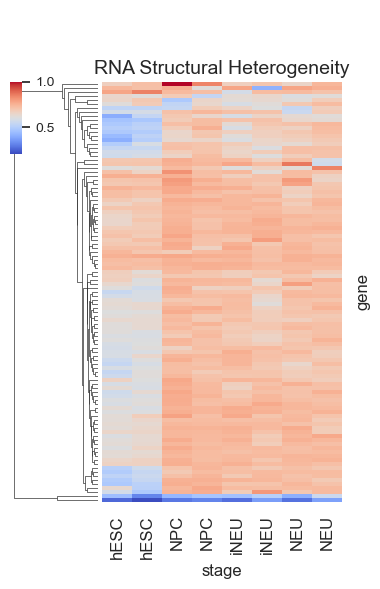

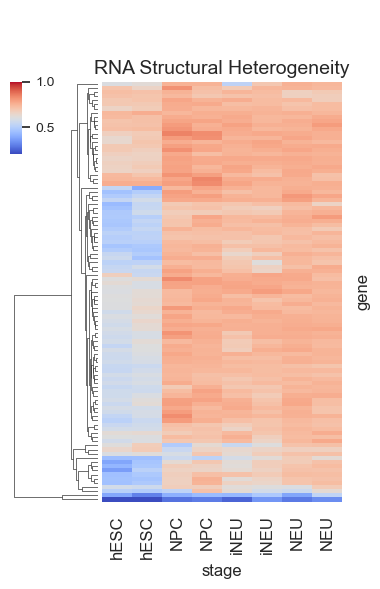

In [7]:
def plot_heatmap_of_gene_htg(gene_htg):
    local_gene_htg = gene_htg.copy()
    local_gene_htg.columns = local_gene_htg.columns.get_level_values('stage')
    local_gene_htg.columns = local_gene_htg.columns.map({'h9':'hESC','day0':'NPC','day1':'iNEU','day7':'NEU'})
    t = pd.CategoricalDtype(categories=['hESC','NPC','iNEU','NEU'], ordered=True)
    local_gene_htg.columns = local_gene_htg.columns.astype(t)
    local_gene_htg.sort_index(axis=1, inplace=True)
    sns.set(rc={"font.size":12,"axes.titlesize":14,"axes.labelsize":12, "xtick.labelsize":12,"ytick.labelsize":10},style="white", font_scale = 1) ##'figure.figsize':(11.7,8.27),
    sns.set_style(style='white')
    g=sns.clustermap(local_gene_htg.dropna(), cmap="coolwarm",  vmax=1, vmin=0.2, figsize=(4,6), col_cluster=False, yticklabels=False,)
    g.ax_cbar.set_position([0.05, 0.73, 0.03, 0.12])
    g.ax_row_dendrogram.set_position([0.05, 0.15, 0.22, 0.7])
    g.ax_heatmap.set_position([0.28, 0.15, 0.6, 0.7])
    #plt.suptitle("RNA Structural Heterogeneity", y=0.92)
    g.ax_heatmap.set_title("RNA Structural Heterogeneity", )
    #plt.savefig("../Results/02.Heterogeneity/gene_heterogeneity_across_stages.heatmap.shared_genes.png", dpi=400)
    plt.show()
    
plot_heatmap_of_gene_htg(gene_htg_by_crude_reac)
plot_heatmap_of_gene_htg(gene_htg_by_gnorm_reac)

In [8]:
gene_htg_by_crude_reac

batch         batch_1                                batch_2            \
stage            day0     day1      day7        h9      day0      day1   
gene                                                                     
AARS1             NaN      NaN       NaN  0.753583       NaN       NaN   
AC005329.1        NaN      NaN       NaN  0.683327       NaN       NaN   
AC009107.2        NaN      NaN       NaN  0.700684       NaN       NaN   
AC009446.1        NaN      NaN       NaN  0.786150       NaN       NaN   
AC010624.5        NaN      NaN       NaN  0.786787       NaN       NaN   
...               ...      ...       ...       ...       ...       ...   
ZNRD2             NaN      NaN       NaN  0.595210       NaN       NaN   
ZRANB2            NaN      NaN       NaN  0.820968       NaN       NaN   
ZSCAN10           NaN      NaN       NaN  0.708807       NaN       NaN   
ZYX               NaN      NaN       NaN  0.690197       NaN       NaN   
human_small  0.280336  0.26376  0.269408  0.251246  0.303343  0.356692   

batch                            
stage            day7        h9  
gene                             
AARS1             NaN  0.594882  
AC005329.1        NaN  0.645556  
AC009107.2        NaN  0.717376  
AC009446.1        NaN  0.539029  
AC010624.5        NaN  0.559974  
...               ...       ...  
ZNRD2             NaN  0.565011  
ZRANB2            NaN  0.687041  
ZSCAN10           NaN  0.659282  
ZYX               NaN  0.666559  
human_small  0.365779  0.136482  

[1192 rows x 8 columns]

In [7]:
#gene_htg_by_crude_reac.to_csv("../Current_Data/05.Gene_Heterogeneity/gene_heterogeneity_h9.distribution.deviation_of_cosine_distance.by_crude_reac.csv")
gene_htg_by_crude_reac = load_large_dataFrame("../Current_Data/05.Gene_Heterogeneity/gene_heterogeneity_h9.distribution.deviation_of_cosine_distance.by_crude_reac.csv", header=[0,1])
gene_htg_by_crude_reac

batch         batch_1                                batch_2            \
stage            day0     day1      day7        h9      day0      day1   
gene                                                                     
AARS1             NaN      NaN       NaN  0.753583       NaN       NaN   
AC005329.1        NaN      NaN       NaN  0.683327       NaN       NaN   
AC009107.2        NaN      NaN       NaN  0.700684       NaN       NaN   
AC009446.1        NaN      NaN       NaN  0.786150       NaN       NaN   
AC010624.5        NaN      NaN       NaN  0.786787       NaN       NaN   
...               ...      ...       ...       ...       ...       ...   
ZNRD2             NaN      NaN       NaN  0.595210       NaN       NaN   
ZRANB2            NaN      NaN       NaN  0.820968       NaN       NaN   
ZSCAN10           NaN      NaN       NaN  0.708807       NaN       NaN   
ZYX               NaN      NaN       NaN  0.690197       NaN       NaN   
human_small  0.280336  0.26376  0.269408  0.251246  0.303343  0.356692   

batch                            
stage            day7        h9  
gene                             
AARS1             NaN  0.594882  
AC005329.1        NaN  0.645556  
AC009107.2        NaN  0.717376  
AC009446.1        NaN  0.539029  
AC010624.5        NaN  0.559974  
...               ...       ...  
ZNRD2             NaN  0.565011  
ZRANB2            NaN  0.687041  
ZSCAN10           NaN  0.659282  
ZYX               NaN  0.666559  
human_small  0.365779  0.136482  

[1192 rows x 8 columns]

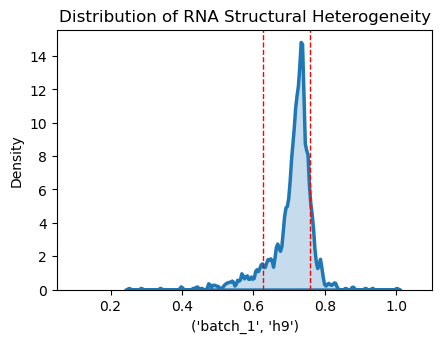

In [117]:
fig, ax = plt.subplots(1,1, figsize=(5,4))

#sns.move_legend(g, loc="upper left")
ax.xaxis.set_ticks_position('bottom')
ax.yaxis.set_ticks_position('left')


sns.kdeplot(gene_htg_by_crude_reac[('batch_1','h9')], common_norm=False, ax=ax, lw=2.5, fill=True, bw_method=0.05)
ax.set_xlim(0.05,1.1)
plt.axvline(x=gene_htg_by_crude_reac[('batch_1','h9')].quantile(0.1), color="red", ls="--", lw=1)
plt.axvline(x=gene_htg_by_crude_reac[('batch_1','h9')].quantile(0.9), color="red", ls="--", lw=1)
fig.subplots_adjust(top=.85, bottom=0.2, left=0.2, right=.95)
plt.title("Distribution of RNA Structural Heterogeneity")
#plt.savefig("../Current_Figures/06.Heterogeneity_Distribution/gene_heterogeneity_h9.distribution.deviation_of_cosine_distance.by_crude_reac.top10pct.pdf", dpi=400)
plt.show()

In [12]:
print (
gene_htg_by_crude_reac[('batch_1','h9')].quantile(0.1),
gene_htg_by_crude_reac[('batch_1','h9')].quantile(0.25),
gene_htg_by_crude_reac[('batch_1','h9')].quantile(0.75),
gene_htg_by_crude_reac[('batch_1','h9')].quantile(0.9))

0.6267791472042011 0.6906935709234919 0.7397936495637233 0.7591994250711269


### 1.4 gene heterogeneity vs gene expr

In [11]:
gene_expr = load_large_dataFrame("../../Gene_Expr/gene_expr.TPM.txt", header=[0,1,2,3,4], index_col=[0])
gene_expr = gene_expr.xs('nai-n3', level="agent", axis=1)
avg_gene_expr = gene_expr.groupby(level=['batch','stage'], axis=1).mean()
avg_gene_expr

batch               batch_1                                               \
stage                  day0           day1           day7             h9   
transcript                                                                 
OR4F5              0.000000       0.000000       0.000000       0.000000   
OR4F29             0.000000       0.000000       0.000000       0.000000   
OR4F16             0.000000       0.000000       0.000000       0.000000   
SAMD11             0.000000       0.005083       0.000000       0.002179   
NOC2L              8.810729      12.500923       3.018416      25.274083   
...                     ...            ...            ...            ...   
LINC00266-4P       0.000000       0.000000       1.173387       0.016915   
CSPG4P1Y           0.000000       0.000000       0.000000       0.000000   
TTTY3              0.000000       0.000000       0.000000       0.000000   
human_small   434717.765667  479003.231979  499387.717027  316691.278714   
human_large    28326.460450   26588.398695   29049.964017   23996.635931   

batch               batch_2                                               
stage                  day0           day1           day7             h9  
transcript                                                                
OR4F5              0.364100       0.154567       0.069965       0.000000  
OR4F29             0.000000       0.000000       0.000000       0.000000  
OR4F16             0.000000       0.000000       0.000000       0.000000  
SAMD11             0.000000       4.174400       0.000000       0.266743  
NOC2L             15.567407       0.078082      10.834019      26.868215  
...                     ...            ...            ...            ...  
LINC00266-4P       0.000000       0.000000       0.462380       0.221572  
CSPG4P1Y           0.000000       0.000000       0.000000       0.000000  
TTTY3              0.000000       0.000000       0.000000       0.000000  
human_small   474101.669410  351943.026775  374944.254585  319189.429667  
human_large    30206.698679   16751.029846   15452.202221   17763.184840  

[38275 rows x 8 columns]

-2.3472533404368097e-05 0.7174235579268903 -0.4139145704075473 4.7406067920752105e-50 1.5040720933146882e-06


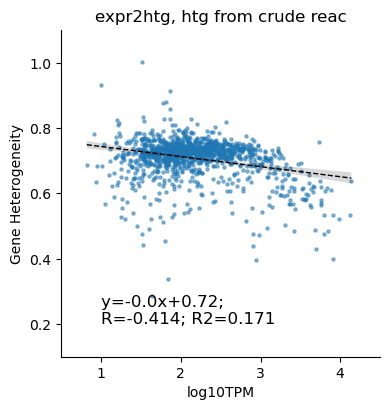

-3.651901982222923e-05 0.7360902266535541 -0.6526225992545892 6.501274418942128e-133 1.2871517723807603e-06


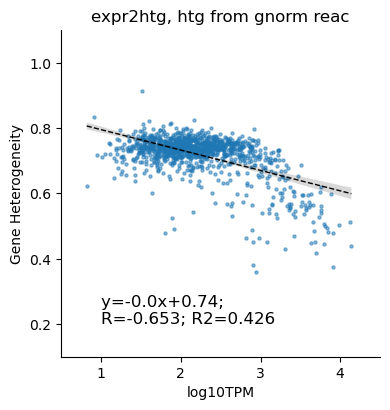

-3.722149378768617e-05 0.6818529879988633 -0.6424873601650295 1.400017883837259e-127 1.3477553352994517e-06


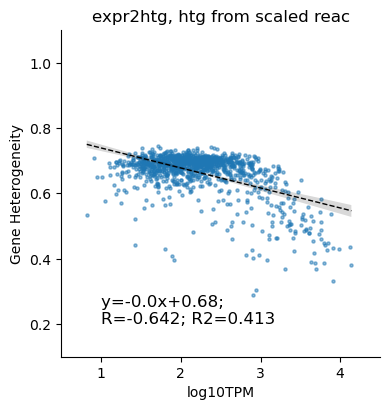

In [121]:
for col_id in gene_htg_by_crude_reac.columns:
    if (col_id[0] == "batch_1") & (col_id[1] == "h9"):
        
        
        
        expr2htg = pd.concat([avg_gene_expr[[col_id]], gene_htg_by_crude_reac[[col_id]]], axis=1)
        expr2htg.columns = ['TPM','Gene Heterogeneity']
        expr2htg = expr2htg.dropna()
        expr2htg['log10TPM'] = np.log10(expr2htg['TPM'])
        expr2htg = expr2htg.loc[expr2htg['TPM']<20000]
        slope, intercept, rvalue, pvalue, _ = stats.linregress(expr2htg['TPM'], expr2htg['Gene Heterogeneity'])
        print (slope, intercept, rvalue, pvalue, _)
        g = sns.lmplot(data=expr2htg, x="log10TPM", y="Gene Heterogeneity", ci=95, height=4,
                       scatter_kws={'s':5,"alpha":0.5}, line_kws={'color':"black","lw":1,"ls":"--"},)
        g.ax.set_xlim(0.5,4.5)
        g.ax.set_ylim(0.1,1.1)
        g.ax.text(1.0,0.2,"y={slope}x+{intercept}; \nR={R}; R2={R2}".format(slope=np.round(slope,2), intercept=np.round(intercept, 2), 
                                                                R=np.round(rvalue,3), R2=np.round(rvalue**2,3)), fontsize=12)
        g.ax.set_title("expr2htg, htg from crude reac")
        g.ax.tick_params(bottom='on',left='on')
        plt.savefig("../Current_Figures/10.Gene_Heterogeneity_to_Gene_Expr/scatterplot.correlation.crude_reac.svg")
        plt.show()
        
        expr2htg = pd.concat([avg_gene_expr[[col_id]], gene_htg_by_gnorm_reac[[col_id]]], axis=1)
        expr2htg.columns = ['TPM','Gene Heterogeneity']
        expr2htg = expr2htg.dropna()
        expr2htg['log10TPM'] = np.log10(expr2htg['TPM'])
        expr2htg = expr2htg.loc[expr2htg['TPM']<20000]
        slope, intercept, rvalue, pvalue, _ = stats.linregress(expr2htg['TPM'], expr2htg['Gene Heterogeneity'])
        print (slope, intercept, rvalue, pvalue, _)
        g = sns.lmplot(data=expr2htg, x="log10TPM", y="Gene Heterogeneity", ci=95, height=4,
                       scatter_kws={'s':5,"alpha":0.5}, line_kws={'color':"black","lw":1,"ls":"--"},)
        g.ax.set_xlim(0.5,4.5)
        g.ax.set_ylim(0.1,1.1)
        g.ax.text(1.0,0.2,"y={slope}x+{intercept}; \nR={R}; R2={R2}".format(slope=np.round(slope,2), intercept=np.round(intercept, 2), 
                                                                 R=np.round(rvalue,3), R2=np.round(rvalue**2,3)), fontsize=12)
        g.ax.set_title("expr2htg, htg from gnorm reac")
        g.ax.tick_params(bottom='on',left='on')
        plt.savefig("../Current_Figures/10.Gene_Heterogeneity_to_Gene_Expr/scatterplot.correlation.gnorm_reac.svg")
        plt.show()
        
        expr2htg = pd.concat([avg_gene_expr[[col_id]], gene_htg_by_scaled_reac[[col_id]]], axis=1)
        expr2htg.columns = ['TPM','Gene Heterogeneity']
        expr2htg = expr2htg.dropna()
        expr2htg['log10TPM'] = np.log10(expr2htg['TPM'])
        expr2htg = expr2htg.loc[expr2htg['TPM']<20000]
        slope, intercept, rvalue, pvalue, _ = stats.linregress(expr2htg['TPM'], expr2htg['Gene Heterogeneity'])
        print (slope, intercept, rvalue, pvalue, _)
        g = sns.lmplot(data=expr2htg, x="log10TPM", y="Gene Heterogeneity", ci=95, height=4, 
                       scatter_kws={'s':5,"alpha":0.5}, line_kws={'color':"black","lw":1,"ls":"--"},)
        g.ax.set_xlim(0.5,4.5)
        g.ax.set_ylim(0.1,1.1)
        g.ax.text(1.0,0.2,"y={slope}x+{intercept}; \nR={R}; R2={R2}".format(slope=np.round(slope,2), intercept=np.round(intercept, 2), 
                                                                            R=np.round(rvalue,3), R2=np.round(rvalue**2,3)), fontsize=12)
        g.ax.set_title("expr2htg, htg from scaled reac")
        
        
       
        #g.ax.tick_params('x',which='major',
        #                 length=5,width = 1.0,
        #                 colors = 'black')
        #g.ax.tick_params('y',which='major',
        #                   length=5,width = 1.0,
        #                   colors = 'black')
       
        #g.ax.tick_params(top='off',bottom='on',left='on',right='off')
        g.ax.tick_params(bottom='on',left='on')
        plt.savefig("../Current_Figures/10.Gene_Heterogeneity_to_Gene_Expr/scatterplot.correlation.scaled_reac.svg")
        plt.show()

In [81]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.ticker import AutoMinorLocator,MultipleLocator,FuncFormatter

#设置刻度线向外还是向内
plt.rcParams['xtick.direction'] = 'in'
plt.rcParams['ytick.direction'] = 'in'

x = np.linspace(0.5,3.5,100)
y = np.sin(x)

fig = plt.figure(figsize = (8,8))
ax = fig.add_subplot(111)

#设置x，y 的主刻度定位器
ax.xaxis.set_major_locator(MultipleLocator(1.0))
ax.yaxis.set_major_locator(MultipleLocator(1.0))

#设置x，y 的次刻度定位器
ax.xaxis.set_minor_locator(AutoMinorLocator(4))
ax.yaxis.set_minor_locator(AutoMinorLocator(4))

#设置x的次刻度格式器
def minor_tick(x, pos):
    if not x % 1.0:
        return ""
    return "%.2f" % x

ax.xaxis.set_minor_formatter(FuncFormatter(minor_tick))
#ax.yaxis.set_minor_formatter(FuncFormatter(minor_tick))

#改变刻度和刻度标签的外观
ax.tick_params("x",which="major",
               length=15,width = 2.0, colors = "r",
               colors = "0.25")
ax.tick_params("y",which="major",
               length=15,width = 2.0, colors = "r",
               colors = "0.25")
ax.tick_params(which = "minor",
               length = 5, width = 1.0, colors = "r",
               labelsize=10,labelcolor = "0.25")

#设置x,y轴的范围
ax.set_xlim(0,4)
ax.set_ylim(0,2)

#在子图画画
ax.plot(x,y,c = (0.25,0.25,1.00),lw = 2,zorder = 10)#pair0
#ax.plot(x,y,c = (0.25,0.25,1.00),lw = 2,zorder = 0)#pair1

#设置网格
ax.grid(linestyle=":",linewidth = 0.5,color = "r",zorder = 0)#pair0
#ax.grid(linestyle="-",linewidth = 0.5,color = "r",zorder = 10)#pair1
#ax.grid(linestyle="--",linewidth = 0.5,color = ".25",zorder = 0)#only one
#plt.show()

SyntaxError: keyword argument repeated: colors (3532776216.py, line 33)

### 1.5 GO of most Homogeneous/Heterogeneous 

In [119]:
import rpy2

In [124]:
expr2htg['htg.qtl'] = pd.qcut(expr2htg['Gene Heterogeneity'], [0,0.25,0.5,0.75,1], [0.25,0.5,0.75,1])
expr2htg.to_csv("../Current_Figures/10.Gene_Heterogeneity_to_Gene_Expr/expr2htg.csv")

## 2. htg from mutrate

In [6]:
## Retrieve mutrate matrix
b1_h9_mutrate = load_large_dataFrame("../Current_Data/02.Mutant_Rate_Matrix.1nt//neural_differentiation.mutrate_data/batch_1.h9.mutrate.1nt.csv", header=[0,1,2,3,4], index_col=[0,1])
b2_h9_mutrate = load_large_dataFrame("../Current_Data/02.Mutant_Rate_Matrix.1nt/neural_differentiation.mutrate_data/batch_2.h9.mutrate.1nt.csv", header=[0,1,2,3,4], index_col=[0,1])
b1_day0_mutrate = load_large_dataFrame("../Current_Data/02.Mutant_Rate_Matrix.1nt/neural_differentiation.mutrate_data/batch_1.day0.mutrate.1nt.csv", header=[0,1,2,3,4], index_col=[0,1])
b2_day0_mutrate = load_large_dataFrame("../Current_Data/02.Mutant_Rate_Matrix.1nt/neural_differentiation.mutrate_data/batch_2.day0.mutrate.1nt.csv", header=[0,1,2,3,4], index_col=[0,1])
b1_day1_mutrate = load_large_dataFrame("../Current_Data/02.Mutant_Rate_Matrix.1nt/neural_differentiation.mutrate_data/batch_1.day1.mutrate.1nt.csv", header=[0,1,2,3,4], index_col=[0,1])
b2_day1_mutrate = load_large_dataFrame("../Current_Data/02.Mutant_Rate_Matrix.1nt/neural_differentiation.mutrate_data/batch_2.day1.mutrate.1nt.csv", header=[0,1,2,3,4], index_col=[0,1])
b1_day7_mutrate = load_large_dataFrame("../Current_Data/02.Mutant_Rate_Matrix.1nt/neural_differentiation.mutrate_data/batch_1.day7.mutrate.1nt.csv", header=[0,1,2,3,4], index_col=[0,1])
b2_day7_mutrate = load_large_dataFrame("../Current_Data/02.Mutant_Rate_Matrix.1nt/neural_differentiation.mutrate_data/batch_2.day7.mutrate.1nt.csv", header=[0,1,2,3,4], index_col=[0,1])

h9_mutrate = pd.concat([b1_h9_mutrate, b2_h9_mutrate], axis=1)
day0_mutrate = pd.concat([b1_day0_mutrate, b2_day0_mutrate], axis=1)
day1_mutrate = pd.concat([b1_day1_mutrate, b2_day1_mutrate], axis=1)
day7_mutrate = pd.concat([b1_day7_mutrate, b2_day7_mutrate], axis=1)

h9_mutrate = h9_mutrate.loc[h9_mutrate.isnull().sum(axis=1) < h9_mutrate.columns.size*0.5]
day0_mutrate = day0_mutrate.loc[day0_mutrate.isnull().sum(axis=1) < day0_mutrate.columns.size*0.5]
day1_mutrate = day1_mutrate.loc[day1_mutrate.isnull().sum(axis=1) < day1_mutrate.columns.size*0.5]
day7_mutrate = day7_mutrate.loc[day7_mutrate.isnull().sum(axis=1) < day7_mutrate.columns.size*0.5]

### add rRNAs
rRNA_df = load_large_dataFrame("../Current_Data/02.Mutant_Rate_Matrix.1nt/neural_differentiation.mutrate_data/all_cells.mutrate.rRNA.1nt.csv", header=[0,1,2,3,4], index_col=[0,1])
def add_rRNA_data(rRNA_df, df):
    df = df.loc[~df.index.get_level_values('gene').isin(['human_small', 'human_large'])]
    df = pd.concat([df, rRNA_df], join="inner")
    return df
h9_mutrate = add_rRNA_data(rRNA_df, h9_mutrate)
day0_mutrate = add_rRNA_data(rRNA_df, day0_mutrate)
day1_mutrate = add_rRNA_data(rRNA_df, day1_mutrate)
day7_mutrate = add_rRNA_data(rRNA_df, day7_mutrate)

mutrate_df = pd.concat([h9_mutrate, day0_mutrate, day1_mutrate, day7_mutrate], axis=1)
mutrate_df.loc[:, ~mutrate_df.columns.get_level_values('id').isin(['RHE1585', 'RHE1614','RHE1587','RHE1615','RHE1600','RHE1653','RHE1602','RHE1655','RHE1584'])]
mutrate_df


id            RHE1534   RHE1540   RHE1546   RHE1552   RHE1558   RHE1564  \
batch         batch_1   batch_1   batch_1   batch_1   batch_1   batch_1   
stage              h9        h9        h9        h9        h9        h9   
agent            dmso      dmso      dmso    nai-n3    nai-n3    nai-n3   
lib_type       single    single    single    single    single    single   
gene   pos                                                                
AARS1  3160  0.007692  0.014925  0.015660  0.002475  0.003272  0.009426   
       3161  0.000000  0.000000  0.006726  0.012346  0.015267  0.000855   
       3162  0.046154  0.006397  0.008969  0.000000  0.001095  0.004274   
       3163  0.000000  0.002137  0.006726  0.002433  0.000000  0.006838   
       3164  0.000000  0.008493  0.004444  0.007246  0.002181  0.002564   
...               ...       ...       ...       ...       ...       ...   
TUBA1A 1004       NaN       NaN       NaN       NaN       NaN       NaN   
       1005       NaN       NaN       NaN       NaN       NaN       NaN   
       1006       NaN       NaN       NaN       NaN       NaN       NaN   
       1664       NaN       NaN       NaN       NaN       NaN       NaN   
       1665       NaN       NaN       NaN       NaN       NaN       NaN   

id            RHE1570 RHE1576 RHE1577 RHE1578  ...   RHN1702   RHN1703  \
batch         batch_1 batch_1 batch_1 batch_1  ...   batch_2   batch_2   
stage              h9      h9      h9      h9  ...      day7      day7   
agent          nai-n3  nai-n3  nai-n3  nai-n3  ...    nai-n3    nai-n3   
lib_type       single  single  single  single  ...    single    single   
gene   pos                                     ...                       
AARS1  3160  0.004772     NaN     NaN     NaN  ...       NaN       NaN   
       3161  0.007534     NaN     NaN     NaN  ...       NaN       NaN   
       3162  0.006845     NaN     NaN     NaN  ...       NaN       NaN   
       3163  0.007550     NaN     NaN     NaN  ...       NaN       NaN   
       3164  0.000682     NaN     NaN     NaN  ...       NaN       NaN   
...               ...     ...     ...     ...  ...       ...       ...   
TUBA1A 1004       NaN     NaN     NaN     NaN  ...  0.006573  0.001988   
       1005       NaN     NaN     NaN     NaN  ...  0.019981  0.013699   
       1006       NaN     NaN     NaN     NaN  ...  0.018044  0.011719   
       1664       NaN     NaN     NaN     NaN  ...  0.020833  0.572727   
       1665       NaN     NaN     NaN     NaN  ...  0.301136  0.200820   

id            RHN1704  RHN1705   RHN1706 RHN1707   RHN1708   RHN1709  \
batch         batch_2  batch_2   batch_2 batch_2   batch_2   batch_2   
stage            day7     day7      day7    day7      day7      day7   
agent          nai-n3   nai-n3    nai-n3  nai-n3      dmso      dmso   
lib_type       single   single    single  single    single    single   
gene   pos                                                             
AARS1  3160       NaN      NaN       NaN     NaN       NaN       NaN   
       3161       NaN      NaN       NaN     NaN       NaN       NaN   
       3162       NaN      NaN       NaN     NaN       NaN       NaN   
       3163       NaN      NaN       NaN     NaN       NaN       NaN   
       3164       NaN      NaN       NaN     NaN       NaN       NaN   
...               ...      ...       ...     ...       ...       ...   
TUBA1A 1004       NaN      NaN  0.003802     NaN  0.008518  0.004789   
       1005       NaN      NaN  0.015504     NaN  0.033077  0.022757   
       1006       NaN      NaN  0.019380     NaN  0.013087  0.018018   
       1664  0.739726  0.15873       NaN     NaN  0.160305  0.056604   
       1665  0.031746      NaN       NaN     NaN  0.132743  0.089595   

id            RHN1710   RHN1711  
batch         batch_2   batch_2  
stage            day7      day7  
agent            dmso      dmso  
lib_type       single    single  
gene   pos                       
AARS1  3160       NaN       NaN  
  